# Import packages

In [104]:
import geopandas as gpd
import matplotlib.patches as mpatches
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd
import os
#import functions as fn
import rasterio
from rasterio.plot import show
from shapely.ops import unary_union
from shapely.validation import make_valid
from shapely.ops import nearest_points
import numpy as np

### Set parameters

In [105]:
year = 2005 #2005 is the base year for the matching process 
crs =  'EPSG:3148'
threshold = 85

## Load relevant files

# Fuzzy Matching

In [106]:
# import needed packages
from rapidfuzz.process import extractOne
from thefuzz import fuzz, process

In [ ]:
root_path = 'DISES/Proximity/data' #https://drive.google.com/open?id=18ttY1vG89yW1TT4UNwBPimaUsl0nKvqt&usp=drive_fs

# define path
os.chdir(root_path)

### Import required datasets

In [108]:
#Updated community forests
cfs_upd = gpd.read_file('Camboda CF updated data - Feb-2025/CF_KH_Updated_2.5.2025_EPSG32648.shp')

#Villages
vlgs = gpd.read_file('KHM-Villages/Villages.shp').to_crs(cfs_upd.crs)

### CFs dataset preprocessing

In [109]:
#Create the CF code for further identification
cfs_upd.rename({'ObjectID':'CF_CODE'}, axis=1, inplace=True)
# Keep only relevant columns
cfs_upd = cfs_upd[['CF_CODE','CF_Name_En', '#Villages','Village', 'Commune', 'geometry']].copy()
# Standarize the commune variable
cfs_upd['Commune'] = cfs_upd['Commune'].str.lower()
# Sort values by ObjectID
cfs_upd.sort_values('CF_CODE', inplace=True)
#Drop the previous index
cfs_upd = cfs_upd.reset_index(drop=True)
#Create a string 3 digit code to uniquely identify the CFs
cfs_upd['CF_CODE'] = cfs_upd['CF_CODE'].astype(str).str.zfill(3)

In [110]:
#Count community forests
cfs_upd_original = cfs_upd.copy()
print(f'There are {str(cfs_upd_original.nunique()['CF_CODE'])} community forests in the updated dataset.' )

There are 598 community forests in the updated dataset.


In [111]:
# Count only those with a village
cfs_with_village = cfs_upd[cfs_upd['Village']!='N/A'].nunique()['CF_CODE']
print(f'However, only {cfs_with_village} had a village assigned.' )

However, only 376 had a village assigned.


## Split villages in multiple columns

In [112]:
vlg_split = cfs_upd['Village'].str.split(',', expand=True) 
vlg_split.columns = [f'Village{i+1}' for i in range(vlg_split.shape[1])]
cfs_upd = cfs_upd.drop(columns=['Village'])

In [113]:
# Concatenate with original DataFrame, dropping the old 'Values' column
df_melted = pd.concat([cfs_upd, vlg_split], axis=1)

In [114]:
# Melt the DataFrame
df_melted = df_melted.melt(id_vars=['CF_CODE'], value_vars=['Village1', 'Village2', 'Village3', 'Village4', 'Village5', 'Village6',
       'Village7'], var_name='vil_type', value_name='vil_melt')

# Drop null values
df_melted = df_melted[df_melted['vil_melt'].notnull()].reset_index(drop=True).copy()

# lowercase village names
df_melted['vil_melt'] = df_melted['vil_melt'].str.lower()

In [115]:
villages_cfs_updated_datasets = df_melted[df_melted['vil_melt'] != 'n/a'].shape[0]
print(f'There are {villages_cfs_updated_datasets} unique villages in the CFs dataset' )

There are 428 unique villages in the CFs dataset


In [116]:
#Drop observations with no Village name
df_melted = df_melted[df_melted['vil_melt'] != 'n/a']

In [117]:
#Get relevant variables from the original data set
cfs_villages = cfs_upd.merge(df_melted, on='CF_CODE', how='left')

## Match only to villages within 5Km of a CF

The georreferenced village dataset did not have a column containing the Commune. For that reason, a sjoin with a dataset of communes downloaded from https://data.humdata.org was performed. 

In [118]:
#Create the 5 km buffer around the CFs
cfs_5k = cfs_upd.copy()
cfs_5k['geometry'] = cfs_5k['geometry'].buffer(5000)

#Save the file
cfs_5k.to_file('cfs_5k_buffer.shp')
cfs_5k = cfs_5k.to_crs(vlgs.crs)

In [119]:
#Sjoin the 5km buffer with the Villages data set to get only proximity villages
villages_5k = gpd.sjoin(
    vlgs[['PHUMCODE', 'VILLAGE', 'geometry']], 
    cfs_5k, 
    how="inner", 
    predicate="within"
)

In [120]:
f"{villages_5k.shape[0]} villages fall within the 5km of CFs"

'5809 villages fall within the 5km of CFs'

In [121]:
#Save the shapefile of villages within 5km
villages_5k.to_file('villages_5k.shp') 

/var/folders/wn/vzyjwy2x00q4stf523pr30jw0000gn/T/ipykernel_12872/2468266793.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  villages_5k.to_file('villages_5k.shp')
/Users/Daniel/miniconda3/envs/pymc_env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(


In [122]:
#Simplify the name for the workflow
df = villages_5k.copy()

In [123]:
#keep only the necessary columns
df = df[['PHUMCODE', 'VILLAGE', 'geometry', 'CF_CODE']]

### Fuzzy matching

In [124]:
#The fuzzy matching is done with this 2 CFs. 
#df #All villages within 5 km of CFs
#cfs_villages #All villages in CFs updates dataset with their corresponding CFs

In [125]:
#Create the 2 dfs for matching
df1 = df[['CF_CODE', 'PHUMCODE', 'VILLAGE']]

df2 = cfs_villages[['CF_CODE', 'vil_melt']]

df2 = df2[~df2['vil_melt'].isnull()]

In [126]:
df1['VILLAGE'] = df1['VILLAGE'].str.lower()

/var/folders/wn/vzyjwy2x00q4stf523pr30jw0000gn/T/ipykernel_12872/1060850753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['VILLAGE'] = df1['VILLAGE'].str.lower()


In [127]:
#Merge the 2 dataframes with CF villages on the left on the left
df3 = df2.merge(df1, on='CF_CODE', how='left')

In [128]:
df3["similarity_score"] = df3.apply(lambda row: fuzz.ratio(row["VILLAGE"], row["vil_melt"]), axis=1)

In [129]:
df_best_matches = df3.loc[
    df3.groupby(["CF_CODE", "vil_melt"])["similarity_score"].idxmax()
].copy()

In [130]:
df_best_matches[df_best_matches['similarity_score']<80].sample(10).sort_values('similarity_score', ascending=False)

,CF_CODE,vil_melt,PHUMCODE,VILLAGE,similarity_score
1971,229,samraong yea,15040707.0,samraong pir,75
3678,586,laom,16010104.0,loum,75
3635,561,doun troet,2090702.0,don traek,74
98,025,sung 1,2090608.0,sung pir,71
1316,196,kampong pou,13020801.0,kampong chrey,67
3342,489,kaoh chheu teal touch,19050805.0,koh lngo,40
108,043,chrouy sna,2040629.0,boeng snuol,38
3325,487,prey kranhoung,19050201.0,rumdeng,38
3429,523,krang doung,NaN,NaN,0
3045,399,mreak kha,NaN,NaN,0


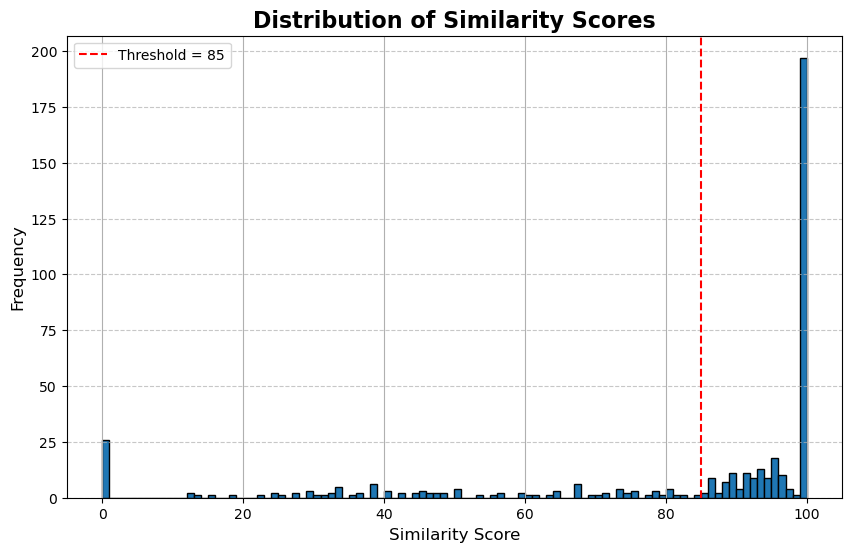

In [131]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 6))
df_best_matches['similarity_score'].hist(bins=100, edgecolor='black')

# Add vertical line at 70
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=1.5, label=f'Threshold = {threshold}')

# Improve appearance
plt.title('Distribution of Similarity Scores', fontsize=16, weight='bold')
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [132]:
#Only similarity scores higher that 60
df3 = df_best_matches[df_best_matches['similarity_score'] > threshold]

In [133]:
df3['PHUMCODE'].nunique()

299

In [134]:
df3['CF_CODE'].nunique()

274

In [135]:
df3 = df3[['CF_CODE', 'PHUMCODE', 'VILLAGE']]

In [136]:
df3 = df3.merge(vlgs[['PHUMCODE', 'geometry']], on='PHUMCODE', how='left')

In [137]:
gdf = gpd.GeoDataFrame(df3)

In [138]:
#Save the matching villages gdf as a shapefile
#gdf.to_file('matched_villages.shp')

## Finding the "nearest" villages for non-matched CFs

In [139]:
#Get all CFs that have no matching village so far
cfs1 = cfs_upd[~cfs_upd['CF_CODE'].isin(df3['CF_CODE'])]

In [140]:
def find_closest_phumcode(gdf1, gdf2):
    """
    Find the PHUMCODE of the closest point from gdf2 to each polygon in gdf1.

    Parameters:
    gdf1 (GeoDataFrame): A GeoDataFrame containing polygon geometries.
    gdf2 (GeoDataFrame): A GeoDataFrame containing point geometries with a 'PHUMCODE' column.

    Returns:
    GeoDataFrame: The original gdf1 with an additional column 'closest_phumcode' 
                  containing the PHUMCODE of the nearest point from gdf2.
    
    Example:
    --------
    # Load example data
    gdf1 = gpd.read_file('polygons.shp')
    gdf2 = gpd.read_file('points.shp')

    # Find closest PHUMCODE
    result = find_closest_phumcode(gdf1, gdf2)
    """
    closest_phumcodes = []
    for _, polygon in gdf1.iterrows():
        # Find the index of the nearest point
        nearest_geom = gdf2.geometry.distance(polygon.geometry).idxmin()
        # Get the corresponding PHUMCODE
        closest_phumcode = gdf2.loc[nearest_geom, 'PHUMCODE']
        closest_phumcodes.append(closest_phumcode)
    
    # Save the closest PHUMCODE to gdf1
    gdf1['PHUMCODE'] = closest_phumcodes
    return gdf1


In [141]:
# Find closest PHUMCODE
result = find_closest_phumcode(cfs1, vlgs)

/Users/Daniel/miniconda3/envs/pymc_env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [142]:
nearest_villages = result[['CF_CODE', 'PHUMCODE']].merge(vlgs, on='PHUMCODE', how='left')

In [143]:
#Unify format
nearest_villages['VILLAGE'] = nearest_villages['VILLAGE'].str.lower()

In [144]:
#gpd.GeoDataFrame(nearest_villages).to_file('closest_villages.shp')

# A unified treatment villages dataset

In [145]:
gdf['Criterion'] = 'Matching'

In [146]:
#Simpllified nearest
nearest_villages['Criterion'] = 'Nearest'
nearest_villages = nearest_villages[gdf.columns]

In [147]:
treatment = pd.concat([gdf, nearest_villages])

In [148]:
treatment['CF_CODE'].nunique()

598

In [149]:
gpd.GeoDataFrame(treatment.drop_duplicates('CF_CODE')).to_file('treatment_villages.shp')